## Sobre el Dataset

> El dataset tiene 2 carpetas
  
> * Infected
> * Uninfected  
  
> Con un total de 27,558 imagenes.

## Tarea
> Modelo que pueda predecir si la celula está o no parasitada

# Librerias

In [ ]:

import os
import glob

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Data

### Lista de archivos

In [2]:
# Dirección del dataset
os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images')

['Uninfected', 'Parasitized']

In [3]:
# Lista de todas las imagenes que representan la clase "Parasitada"
parasitized = glob.glob('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/*.png')

# Cantidad de archivos
print('No. of files in the directory Parasitized', len(parasitized))

parasitized[:5]

No. of files in the directory Parasitized 13779


['../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C99P60ThinF_IMG_20150918_141001_cell_93.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C99P60ThinF_IMG_20150918_141001_cell_133.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C101P62ThinF_IMG_20150918_151942_cell_60.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C162P123ThinF_IMG_20151116_102655_cell_163.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C52P13thinF_IMG_20150725_124830_cell_174.png']

In [4]:
# Lista de todas las imagenes que representan la clase "No Parasitada"
uninfected = glob.glob('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/*.png')

# Cantidad de archivos
print('No. of files in the directory Uninfected', len(uninfected))

uninfected[:5]

No. of files in the directory Uninfected 13779


['../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C203ThinF_IMG_20151029_102123_cell_51.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C238NThinF_IMG_20151207_114038_cell_84.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C119P80ThinF_IMG_20151002_124304_cell_112.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C39P4thinF_original_IMG_20150622_111723_cell_33.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C101P62ThinF_IMG_20150918_151149_cell_63.png']

# Imagenes

/tmp/ipykernel_35/3638847830.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 10, ind+1)


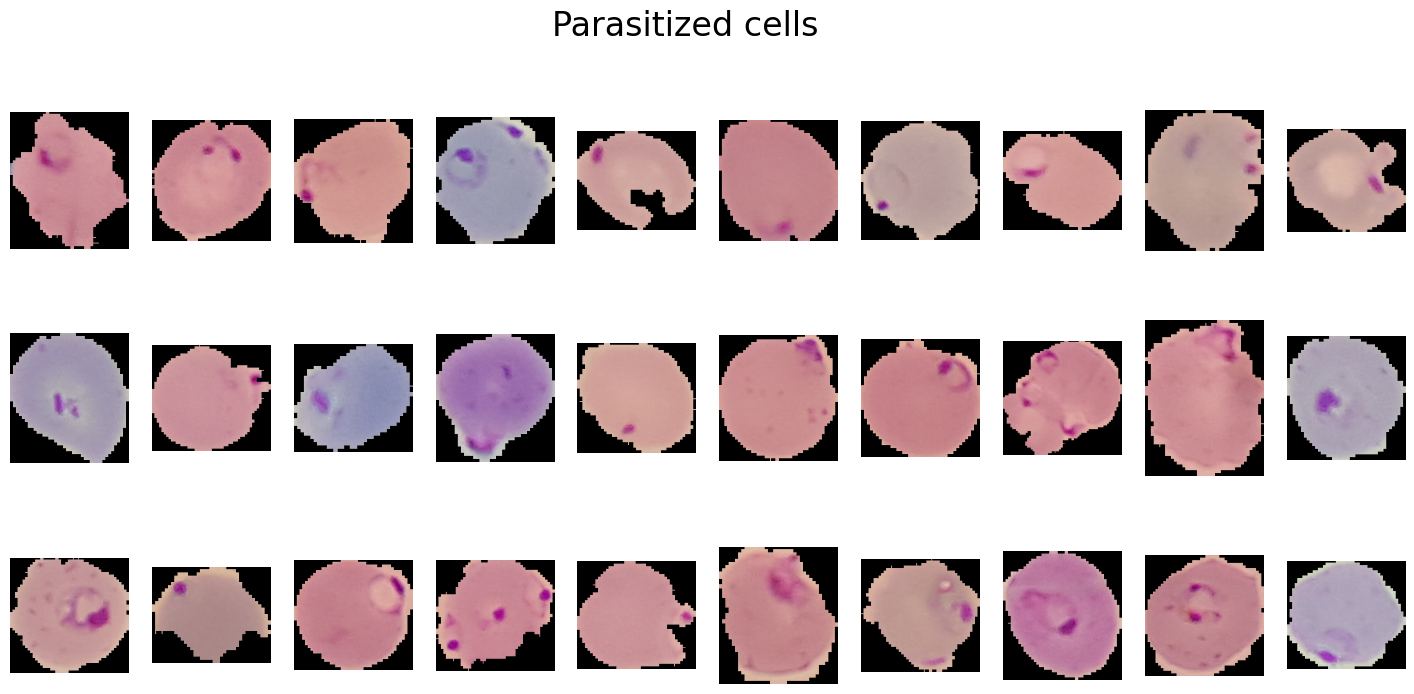

In [5]:
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle('Parasitized cells', fontsize=24)

for ind, img_src in enumerate(parasitized[:30]):
    plt.subplot(3, 10, ind+1)
    img = plt.imread(img_src)
    plt.axis('off')
    plt.imshow(img)

/tmp/ipykernel_35/3420207871.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 10, ind+1)


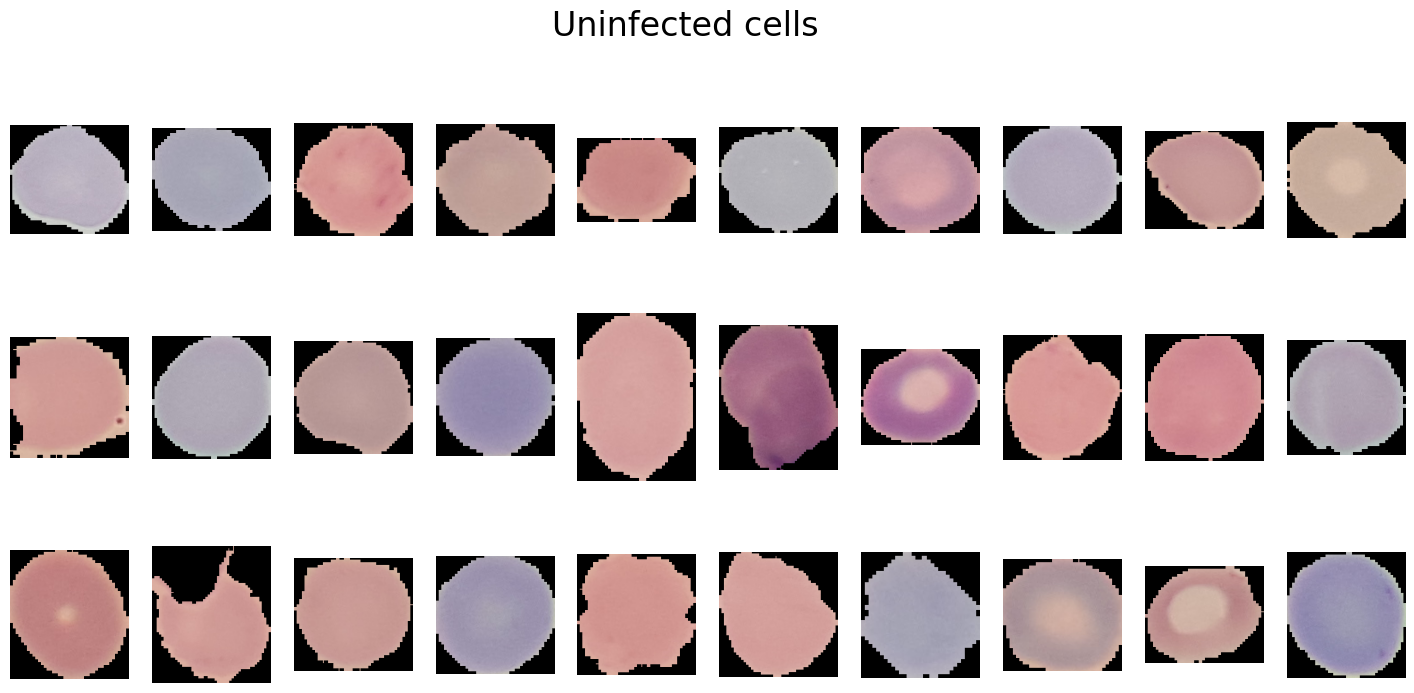

In [6]:
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle('Uninfected cells', fontsize=24)

for ind, img_src in enumerate(uninfected[:30]):
    plt.subplot(3, 10, ind+1)
    img = plt.imread(img_src)
    plt.axis('off')
    plt.imshow(img)

# Modelo

### Parametros

In [13]:
BATCH_SIZE = 100  
IMG_SHAPE  = 150  
IMG_SHAPE  = 224  

TARGET_SIZE = 64
EPOCHS = 10

### Model initialization

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions


In [16]:
# Se carga el modelo EfficientNetB0
model = EfficientNetB0(weights='/kaggle/input/efficientnet/efficientnetb0.h5')

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 5,330,571 (20.33 MB)

 Trainable params: 5,288,548 (20.17 MB)

 Non-trainable params: 42,023 (164.16 KB)

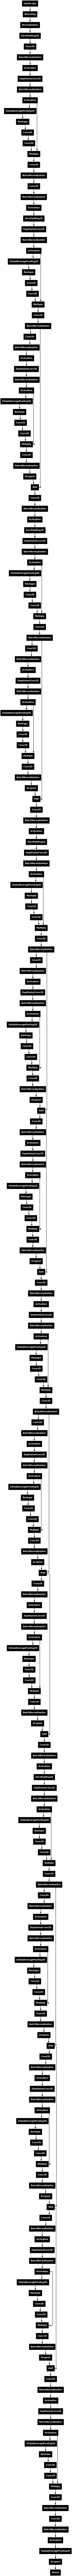

<Figure size 500x1000 with 0 Axes>

In [18]:
plt.figure(figsize=(5, 10))
plot_model(model, to_file="model.png")

### Uso de DataGenerator

In [19]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             validation_split=0.3)

train_data = datagen.flow_from_directory('../input/cell-images-for-detecting-malaria/cell_images/cell_images',
                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         class_mode='binary',
                                         subset='training')

validation_data = datagen.flow_from_directory('../input/cell-images-for-detecting-malaria/cell_images/cell_images',
                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              class_mode='binary',
                                              subset='validation')

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


### Funciones Callback

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta = 0.01,
                               patience=5)

model_save = ModelCheckpoint('best_model.keras',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

### Entrenamiento

In [21]:
history = model.fit(train_data,
                    validation_data=validation_data,
                    epochs=EPOCHS,
                    verbose=1, 
                    callbacks=[early_stopping, model_save])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1719451025.517752     432 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


193/193 ━━━━━━━━━━━━━━━━━━━━ 648s 3s/step - accuracy: 0.8585 - loss: 0.7863 - val_accuracy: 0.5000 - val_loss: 4.8192
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9499 - loss: 0.1445 - val_accuracy: 0.5000 - val_loss: 2.7885
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.9516 - loss: 0.1401 - val_accuracy: 0.5166 - val_loss: 1.2317
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9534 - loss: 0.1357 - val_accuracy: 0.8207 - val_loss: 0.6659
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9575 - loss: 0.1194 - val_accuracy: 0.9216 - val_loss: 0.2347
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9607 - loss: 0.1148 - val_accuracy: 0.9400 - val_loss: 0.1574
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9606 - loss: 0.1069 - val_accuracy: 0.9280 - val_loss: 0.2121
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9606 - loss: 0.1055 - val_accuracy: 0.946

In [59]:
# Funcion para poder evaluar las imagenes en cierto directorio
def evaluate_images(directory, model):

  malaria_images = []
  no_malaria_images = []

  for filename in os.listdir(directory):
      img = load_img(os.path.join(directory, filename), target_size=(IMG_SHAPE, IMG_SHAPE))
      img_array = img
      img_array = np.array(img_array)
      img_array = img_array.reshape(-1, IMG_SHAPE, IMG_SHAPE, 3)
      prediction = model.predict(img_array)
      formatted_prediction = f"{prediction[0][0]:.16f}"
      print(formatted_prediction)
      if float(formatted_prediction) >= 0.001:
          malaria_images.append(filename)
      else:
          no_malaria_images.append(filename)

  percentage = len(malaria_images) * 100 / (len(malaria_images) + len(no_malaria_images))

  print(f"El porcentaje de celulas infectadas por malaria es: ", percentage, "%")
  print(f"Celulas infectadas: {len(malaria_images)}/{len(malaria_images)+len(no_malaria_images)}")

  # Mostrar las imagenes con malaria en un solo recuadro
  plt.figure(figsize=(10, 10))
  for i in range(len(malaria_images)):
      plt.subplot(1, len(malaria_images), i+1)
      img = load_img(os.path.join(directory, malaria_images[i]))
      plt.imshow(img)
      plt.axis('off')
      plt.title('Malaria')
      plt.tight_layout()

  return


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.9982511401176453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.0000000000008716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1.0000000000000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1.0000000000000000
El porcentaje de celulas infectadas por malaria es:  83.33333333333333 %
Celulas infectadas: 10/12


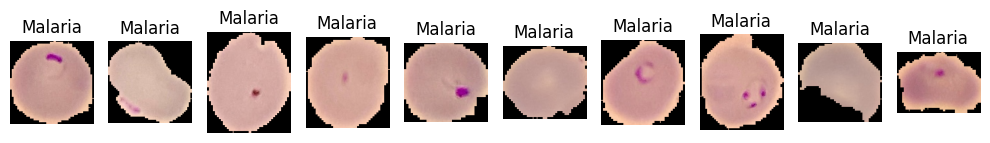

In [60]:
directory = '/kaggle/input/prueba'
evaluate_images(directory, model)

### Metricas

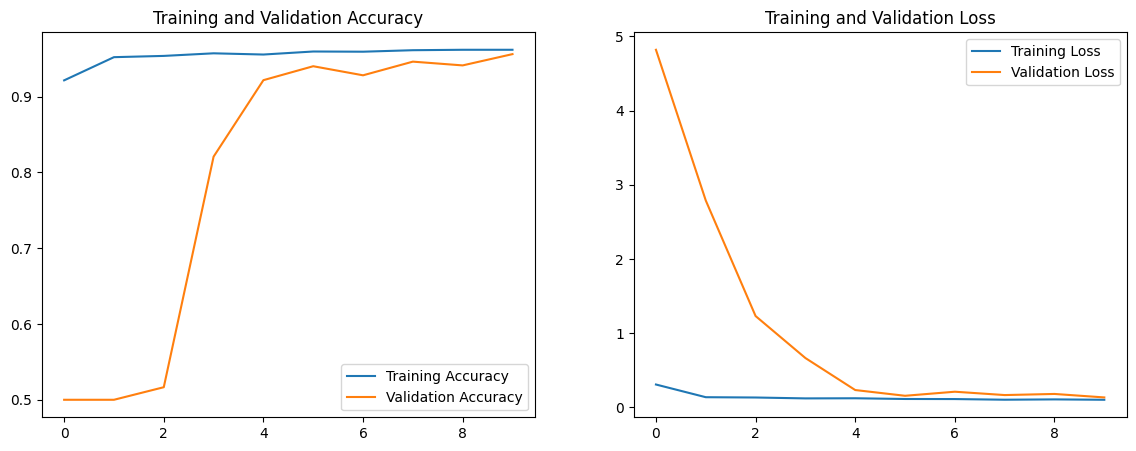

In [24]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

**